### Gathering Data for this Project
Gather each of the three pieces of data as described below in a Jupyter Notebook titled wrangle_act.ipynb:

* The WeRateDogs Twitter archive. I am giving this file to you, so imagine it as a file on hand. Download this file manually by clicking the following link: twitter_archive_enhanced.csv

* The tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network. This file (**image_predictions.tsv**) is hosted on Udacity's servers and should be downloaded programmatically using the ***Requests*** library and the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv

* Each tweet's retweet count and favorite ("like") count at minimum, and any additional data you find interesting. Using the tweet IDs in the WeRateDogs Twitter archive, query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file. Each tweet's JSON data should be written to its own line. Then read this .txt file line by line into a pandas DataFrame with (at minimum) tweet ID, retweet count, and favorite count. Note: do not include your Twitter API keys, secrets, and tokens in your project submission.

Each tweet's retweet count and favorite ("like") count at minimum, and any additional data you find interesting. Using the tweet IDs in the WeRateDogs Twitter archive, query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file. Each tweet's JSON data should be written to its own line. Then read this .txt file line by line into a pandas DataFrame with (at minimum) tweet ID, retweet count, and favorite count.

### Assessing Data for this Project
After gathering each of the above pieces of data, assess them visually and programmatically for quality and tidiness issues. **Detect and document at least eight (8) quality issues and two (2) tidiness issues** in your wrangle_act.ipynb Jupyter Notebook. To meet specifications, the issues that satisfy the Project Motivation (see the Key Points header on the previous page) must be assessed.

### Cleaning Data for this Project
Clean each of the issues you documented while assessing. Perform this cleaning in wrangle_act.ipynb as well. The result should be a high quality and tidy master pandas DataFrame (or DataFrames, if appropriate). Again, the issues that satisfy the Project Motivation must be cleaned.

### Storing, Analyzing, and Visualizing Data for this Project
**Store the clean DataFrame(s) in a CSV file with the main one named twitter_archive_master.csv**. If additional files exist because multiple tables are required for tidiness, name these files appropriately. Additionally, you may store the cleaned data in a SQLite database (which is to be submitted as well if you do).

Analyze and visualize your wrangled data in your wrangle_act.ipynb Jupyter Notebook. At least **three (3) insights and one (1) visualization** must be produced.

### Reporting for this Project
* Create a 300-600 word written report called wrangle_report.pdf or wrangle_report.html that briefly describes your wrangling efforts. This is to be framed as an internal document.

* Create a 250-word-minimum written report called act_report.pdf or act_report.html that communicates the insights and displays the visualization(s) produced from your wrangled data. This is to be framed as an external document, like a blog post or magazine article, for example.

Both of these documents can be created in separate Jupyter Notebooks using the Markdown functionality of Jupyter Notebooks, then downloading those notebooks as PDF files or HTML files (see image below). You might prefer to use a word processor like Google Docs or Microsoft Word, however.

### Key Points
#### Key points to keep in mind when data wrangling for this project:

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.

* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.

* Cleaning includes merging individual pieces of data according to the rules of tidy data.

* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This unique rating system is a big part of the popularity of WeRateDogs.

* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.

### from dog_archive

#### Quality

* timestamp data is an object, should be a timestamp
* retweeted_status_timestamp is an object, should be a timestamp
* all status_ids, and user_ids are floats, should be objects
* name column contains values that are not names
* value in floofer field should be a yes/no, and category type

#### Tidiness
* doggo, pupper, puppo - should be one column and category type

### from image predictions

#### Quality

* tweed_id is an int, should be an object
* rename columns p1, p1_conf, and p1_dog to more clear column names
* for p1 column values, replace underscore with space and make title case

### from Tweepy

#### Quality
* id is an integer, should be an object

#### Tidiness
* all data is in a tweepy.model.resultset and must be converted to a useful json before it can be loaded into pandas

### Merged data

#### Quality
* Retweet and favorite counts are changed to decimal, revert to integer

In [1]:
# import libraries

import pandas as pd
import os
from collections import defaultdict as dd
import re
from io import BytesIO
from io import StringIO
import requests
import tweepy
import math
import json
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Now change the directory
path = r'F:\Udacity\wrangling'
os.chdir(path)

retval = os.getcwd()
print("Current working directory %s" % retval)

#print(os.listdir(retval))

Current working directory F:\Udacity\wrangling


In [3]:
## loading the archived WeRateDogs twitter data

# solution for constricting a path using the os library found at https://stackoverflow.com/a/65273597
file = os.path.join('F:',os.sep,'Udacity','wrangling','twitter-archive-enhanced.csv')
archive = pd.read_csv(file)
dog_archive = archive.copy()

In [4]:
list(dog_archive)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

In [5]:
dog_archive.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1411,698989035503689728,NaN,NaN,2016-02-14 21:55:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Oliver. He does toe touches in his sle...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/698989035...,13,10,Oliver,None,None,None,None
1480,693486665285931008,NaN,NaN,2016-01-30 17:31:20 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Lincoln. He doesn't understand his new...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/693486665...,11,10,Lincoln,None,None,None,None
2303,666996132027977728,NaN,NaN,2015-11-18 15:07:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Carll. He wants to be a donkey. But al...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666996132...,10,10,Carll,None,None,None,None
609,797545162159308800,NaN,NaN,2016-11-12 21:02:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She steals things. Guilt incre...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/797545162...,12,10,Cassie,None,None,None,None
2328,666396247373291520,NaN,NaN,2015-11-16 23:23:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Oh goodness. A super rare northeast Qdoba kang...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666396247...,9,10,None,None,None,None,None
195,855138241867124737,NaN,NaN,2017-04-20 19:16:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @frasercampbell_: oh my... what's that... b...,8.551225e+17,7.475543e+17,2017-04-20 18:14:33 +0000,https://twitter.com/frasercampbell_/status/855...,14,10,None,None,None,None,None
1671,682393905736888321,NaN,NaN,2015-12-31 02:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Kreg. He's riding an invisible jet ski...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/682393905...,11,10,Kreg,None,None,None,None
2346,666058600524156928,NaN,NaN,2015-11-16 01:01:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is the Rand Paul of retrievers folks! He'...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666058600...,8,10,the,None,None,None,None
1278,708853462201716736,NaN,NaN,2016-03-13 03:13:29 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",This is Lucy. She doesn't understand fetch. 8/...,NaN,NaN,NaN,https://vine.co/v/iHl2UDEBZ95,8,10,Lucy,None,None,None,None
450,818646164899774465,NaN,NaN,2017-01-10 02:30:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Seamus. He's very bad a...,8.083449e+17,4.196984e+09,2016-12-12 16:16:49 +0000,"https://vine.co/v/5QWd3LZqXxd,https://vine.co/...",11,10,Seamus,None,None,None,None


In [6]:
dog_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [7]:
dog_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [8]:
# identifies tweets that are in reply to another tweet
dog_archive[dog_archive.in_reply_to_status_id.notnull()].sample(12)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
570,801854953262350336,8.018543e+17,1.185634e+07,2016-11-24 18:28:13 +0000,"<a href=""http://twitter.com/download/iphone"" r...",.@NBCSports OMG THE TINY HAT I'M GOING TO HAVE...,NaN,NaN,NaN,NaN,11,10,None,None,None,None,None
1016,746906459439529985,7.468859e+17,4.196984e+09,2016-06-26 03:22:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...","PUPDATE: can't see any. Even if I could, I cou...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/746906459...,0,10,None,None,None,None,None
576,800859414831898624,8.008580e+17,2.918590e+08,2016-11-22 00:32:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@SkyWilliams doggo simply protecting you from ...,NaN,NaN,NaN,NaN,11,10,None,doggo,None,None,None
498,813130366689148928,8.131273e+17,4.196984e+09,2016-12-25 21:12:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I've been informed by multiple sources that th...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
1852,675707330206547968,6.754971e+17,4.196984e+09,2015-12-12 16:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We've got ourselves a battle here. Watch out R...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/675707330...,11,10,None,None,None,None,None
1892,674754018082705410,6.747522e+17,4.196984e+09,2015-12-10 00:54:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Just received another perfect photo of dogs an...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/674754018...,12,10,None,None,None,None,None
1452,695767669421768709,6.753494e+17,4.196984e+09,2016-02-06 00:35:13 +0000,"<a href=""http://twitter.com/download/iphone"" r...",If you are aware of who is making these please...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/695767669...,13,10,None,None,None,None,None
1914,674330906434379776,6.658147e+17,1.637468e+07,2015-12-08 20:53:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",13/10\n@ABC7,NaN,NaN,NaN,NaN,13,10,None,None,None,None,None
387,826598799820865537,8.265984e+17,4.196984e+09,2017-02-01 01:11:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...","I was going to do 007/10, but the joke wasn't ...",NaN,NaN,NaN,NaN,7,10,None,None,None,None,None
857,763956972077010945,7.638652e+17,1.584641e+07,2016-08-12 04:35:10 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@TheEllenShow I'm not sure if you know this bu...,NaN,NaN,NaN,NaN,12,10,None,doggo,None,None,None


Not all tweets are just replies, e.g.

* 2169

In [9]:
# filters for original tweets by removing when retweeted_status_id is not null
dog_archive_clean = dog_archive[~dog_archive.retweeted_status_id.notnull()]

# filters for tweets that are not replies to other tweets
dog_archive_clean = dog_archive_clean[~dog_archive_clean.in_reply_to_status_id.notnull()]


After removing retweets and replies, those columns can be dropped as the should be empty

In [10]:
# convert the timpestamp column to a datetime object
dog_archive_clean['timestamp'] = pd.to_datetime(dog_archive_clean.timestamp, format='%Y-%m-%d %H:%M:%S %z')

In [11]:
dog_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2097 non-null   int64              
 1   in_reply_to_status_id       0 non-null      float64            
 2   in_reply_to_user_id         0 non-null      float64            
 3   timestamp                   2097 non-null   datetime64[ns, UTC]
 4   source                      2097 non-null   object             
 5   text                        2097 non-null   object             
 6   retweeted_status_id         0 non-null      float64            
 7   retweeted_status_user_id    0 non-null      float64            
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               2094 non-null   object             
 10  rating_numerator            2097 non-null   int64           

In [12]:
# function to return the non-blank field from doggo, puppo, and pupper

def dog_type(x):
    type_list = x[['doggo','puppo','pupper']].values
    if type_list[type_list != 'None'].size == 0:
        return 'none'
    else:
        return type_list[type_list != 'None'][0]

In [13]:
# use dog_type function and enter the returned value into column type

dog_archive_clean['type'] = dog_archive_clean.apply(dog_type, axis=1)

In [14]:
dog_archive_clean.type.value_counts()

none      1770
pupper     221
doggo       83
puppo       23
Name: type, dtype: int64

This shows that a dozen tweets contain two dogs

def dog_type(x):
    type_list = x[['doggo','puppo','pupper']].values
    return type_list[type_list != 'None'].size
    #if type_list[type_list != 'None'].size == 0:
        #return 'none'
    #else:
        #return type_list[type_list != 'None']

dog_archive_clean['type'] = dog_archive_clean.apply(dog_type, axis=1)

dog_archive_clean.query('type > 1').apply(lambda x: print(x['text']), axis=1)

Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel

This is Dido. She's playing the lead role in "Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple." 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7

Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho

This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj

This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cautiously https://t.co/f2wmLZTPHd

Pupper butt 1, Doggo 0. Both 12/10 https://t.co/WQvcPEpH2u

Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MYwR4DQKll

Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch tho https://t.co/u2c9c7qSg8

This is just downright precious af. 12/10 for both pupper and doggo https://t.co/o5J479bZUC

Like father (doggo), like son (pupper). Both 12/10 https://t.co/pG2inLaOda

In [15]:
# identifies doggos that may be floofer

dog_archive_clean.floofer.value_counts()

None       2087
floofer      10
Name: floofer, dtype: int64

Since the main dataset should only contain tweets from the account and not retweets or replies, the columns about retweets and replies can be dropped. In addition, the columns doggo, pupper, and puppo can be dropped. It would useful to check that those columns do not contain any data before dropping them.

In [16]:
# get column names that contain retweeted and or reply
# can use for checking for empty

matching = [s if "reply" in s else s if 'retweeted' in s else 'na' for s in list(dog_archive_clean)]

matching = set(matching)
matching.remove('na')
list(matching)

['retweeted_status_timestamp',
 'in_reply_to_user_id',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'in_reply_to_status_id']

In [17]:
# uses default dict to generate a dictionary for how many entries are in columns relating to retweeting and replying

val_counts = dd()

for series in matching:
    get_series = dog_archive_clean[series]
    #series_val_counts = get_series.value_counts()
    val_counts[series] = len(get_series.value_counts())


In [18]:
# delete drop columns related to reply or retweeting, and doggo, pupper, and puppo as long as the columns related to replying
# and retweeting are empty

if sum(val_counts.values()) == 0:
    remove_cols = list(matching) + ['doggo','pupper','puppo']
    dog_archive_clean.drop(columns=remove_cols, inplace=True)
    print('columns dropped')
else:
    print('there are still values in columns related to retweeting or replying')

columns dropped


In [19]:
# bulk change columns types
# type and floofer are changed to category

dog_archive_clean = dog_archive_clean.astype({'type': 'category', 'floofer': 'category', 'tweet_id':'object'}
                        )
dog_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2097 non-null   object             
 1   timestamp           2097 non-null   datetime64[ns, UTC]
 2   source              2097 non-null   object             
 3   text                2097 non-null   object             
 4   expanded_urls       2094 non-null   object             
 5   rating_numerator    2097 non-null   int64              
 6   rating_denominator  2097 non-null   int64              
 7   name                2097 non-null   object             
 8   floofer             2097 non-null   category           
 9   type                2097 non-null   category           
dtypes: category(2), datetime64[ns, UTC](1), int64(2), object(5)
memory usage: 151.8+ KB


In [20]:
dog_archive_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,floofer,type
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,none
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,none
2,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,none
3,891689557279858688,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,none
4,891327558926688256,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,none


In [ ]:
# checking rating_numerator for whole numbers

dog_archive_clean.rating_numerator.value_counts()

In [ ]:
dog_archive_clean.rating_denominator.value_counts()

In [21]:
#checking the values in the names column.

dog_archive_clean.name.value_counts()

None       603
a           55
Lucy        11
Charlie     11
Cooper      10
          ... 
Henry        1
Livvie       1
Shelby       1
Chevy        1
Leonard      1
Name: name, Length: 955, dtype: int64

In [22]:
### perform a value_counts of all the names and then create a boolean of those whose name has fewer than 5 letters. 
### That boolean mask is then applied to the name value counts to create a Series containing all names with fewer than
### 5 letters and is saved in variable faux_names

faux_names = dog_archive_clean.name.value_counts()[dog_archive_clean.name.value_counts().index.str.len() <= 4]

### takes the index of faux_names and checks to see if the index icontains an uppercase letter and then 
### inverses the results to create a boolean mask to filter out title case names in faux_names

names_to_correct = faux_names[~faux_names.index.str.contains(r'[A-Z]')].index

bad_dog_names = dog_archive_clean.query('name in @names_to_correct')


In [23]:
bad_dog_names.loc[56,'text']

'Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF'

In [24]:
bad_dog_names.loc[2116,'text']
bad_dog_names.loc[2348,'text']
#bad_dog_names.loc[2311,'text']
bad_dog_names.loc[2348]

tweet_id                                             666055525042405380
timestamp                                     2015-11-16 00:49:46+00:00
source                <a href="http://twitter.com/download/iphone" r...
text                  Here is a Siberian heavily armored polar bear ...
expanded_urls         https://twitter.com/dog_rates/status/666055525...
rating_numerator                                                     10
rating_denominator                                                   10
name                                                                  a
floofer                                                            None
type                                                               none
Name: 2348, dtype: object

In [25]:
# testing regex search

re.search(r'(?<=named )\w+', bad_dog_names.loc[2116,'text']) is not None

True

In [26]:
# testing regex search and matching

re.search(r'(?<=named )\w+', bad_dog_names.loc[2116,'text'])[0]

'Spork'

In [27]:
# function to extract and return the name of the dog if the word 'named' is present

def correct_name(name):
    new_name = ''
    if re.search(r'(?<=named )\w+', name) is not None:
        new_name = re.search(r'(?<=named )\w+', name)[0]
    else:
        new_name = 'No name'
    return new_name

In [28]:
##testing function on test statemen with name a##

name = 'Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF'

correct_name(name)

'No name'

In [29]:
# used to test the results 

dog_archive_clean_test = dog_archive_clean.copy()

In [30]:
dog_archive_clean_test.update(bad_dog_names['name'].apply(correct_name))

In [31]:
# test to determine value counts

dog_archive_clean_test.name.value_counts()

None       603
No name     91
Charlie     11
Lucy        11
Oliver      10
          ... 
Henry        1
Livvie       1
Shelby       1
Chevy        1
Leonard      1
Name: name, Length: 940, dtype: int64

In [32]:
# apply a function that checks to see if the word 'named' is in the text and if so replaces the value in the name column
# with the word that follows 'named' -- ostensibly the dog's name -- else it enteres 'No Name'

#bad_dog_names['name'] = bad_dog_names['text'].apply(lambda x: re.search(r'(?<=named )\w+', x)[0] if re.search(r'(?<=named )\w+', x) 
                                            #is not None else "No Name")
    
bad_dog_names['name'] = bad_dog_names.loc[:,'text'].apply(correct_name)

<ipython-input-32-eae65d795a9d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bad_dog_names['name'] = bad_dog_names.loc[:,'text'].apply(correct_name)


In [33]:
# update the archived data with the corrected names

dog_archive_clean.update(bad_dog_names)

In [34]:
# query on a control index to ensure the name was correctly entered

dog_archive_clean.query('name == "Octaviath"')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,floofer,type
2311,666781792255496192,2015-11-18 00:55:42+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Bacardi named Octaviath. Ca...,https://twitter.com/dog_rates/status/666781792...,10.0,10.0,Octaviath,None,none


In [35]:
# query to check whether the name 'a' remains anywhere in the data set

dog_archive_clean.query('name == "a"')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,floofer,type


In [36]:
dog_archive_clean.name.value_counts()

None       603
No name     71
Lucy        11
Charlie     11
Cooper      10
          ... 
Livvie       1
Shelby       1
Chevy        1
Pherb        1
Leonard      1
Name: name, Length: 957, dtype: int64

In [37]:
# replace names of No name with NaN type object

dog_archive_clean['name'].replace('No name', np.nan, inplace=True)

In [38]:
dog_archive_clean.name.value_counts()

None       603
Lucy        11
Charlie     11
Oliver      10
Cooper      10
          ... 
Livvie       1
Shelby       1
Chevy        1
Pherb        1
Leonard      1
Name: name, Length: 956, dtype: int64

In [39]:
######
# download tweet image predictions from udacity servers
# filename image_predictions.tsv
# file server https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv
######

######
# solution from:
# https://stackoverflow.com/a/50465077
######

tsv_url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

tsv_data = requests.get(tsv_url).content

######
# convert byte object to dataframe
# solution from:
# https://stackoverflow.com/a/65041202
######

img_pred = pd.read_csv(BytesIO(tsv_data), sep="\t")

In [40]:
img_pred.sample(12)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
58,667090893657276420,https://pbs.twimg.com/media/CUH7oLuUsAELWib.jpg,1,Chihuahua,0.959514,True,Italian_greyhound,5.370150e-03,True,Pomeranian,2.641330e-03,True
1378,764259802650378240,https://pbs.twimg.com/media/CpsyNtXWgAAqvs3.jpg,1,German_shepherd,0.973677,True,malinois,2.594970e-02,True,kelpie,1.915680e-04,True
1307,753420520834629632,https://pbs.twimg.com/ext_tw_video_thumb/75342...,1,balloon,0.267961,False,lakeside,8.576370e-02,False,rapeseed,4.080890e-02,False
811,692417313023332352,https://pbs.twimg.com/media/CZv13u5WYAA6wQe.jpg,1,bison,0.208922,False,mink,1.699450e-01,False,polecat,1.444940e-01,False
1062,715220193576927233,https://pbs.twimg.com/media/Cez49UqWsAIRQXc.jpg,1,Chihuahua,0.584026,True,Italian_greyhound,3.770770e-01,True,Boston_bull,1.740040e-02,True
1258,748692773788876800,https://pbs.twimg.com/media/CmPkGhFXEAABO1n.jpg,1,ox,0.337871,False,plow,2.692870e-01,False,oxcart,2.456530e-01,False
265,670803562457407488,https://pbs.twimg.com/media/CU8sSAvXIAAB1Py.jpg,1,basenji,0.344101,True,Ibizan_hound,2.102820e-01,True,toy_terrier,1.962790e-01,True
774,689623661272240129,https://pbs.twimg.com/media/CZIJD2SWIAMJgNI.jpg,1,toy_poodle,0.279604,True,mashed_potato,2.085640e-01,False,Labrador_retriever,7.748090e-02,True
1880,846874817362120707,https://pbs.twimg.com/media/C8C0JYHW0AAy-7u.jpg,2,Shetland_sheepdog,0.450539,True,papillon,1.879280e-01,True,collie,1.400680e-01,True
292,671186162933985280,https://pbs.twimg.com/media/CVCIQX7UkAEzqh_.jpg,1,Chihuahua,0.319106,True,whippet,1.691340e-01,True,toy_terrier,1.258150e-01,True


In [41]:
img_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [137]:
#output the image predictions file to local storage

img_pred.to_csv('image_predictions.tsv')

In [ ]:
# build the auth class and prepare to access to twitter API

consumer_key = 'n/a'
consumer_secret = 'n/a'
access_token = 'n/a'
access_secret = 'n/a'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

tweepy docs page

http://docs.tweepy.org/en/latest/api.html#timeline-methods

example page for bulk querying using tweepy

https://stackoverflow.com/questions/44581647/retrieving-a-list-of-tweets-using-tweet-id-in-tweepy

In [43]:
# get list of tweet ids from the twitter archive

tweet_id_list = dog_archive_clean.tweet_id.tolist()

In [42]:
# a function to bulk query the twitter API using the list of tweet ids

def retrieve_tweets(tweet_IDs, api):
    full_tweets = []
    tweet_count = len(tweet_IDs)
    try:
        for i in range(math.floor(tweet_count / 100) + 1):
        # Catch the last group if it is less than 100 tweets
            end_loc = min((i + 1) * 100, tweet_count)
            #print(i*100, end_loc)
            #print(tweet_ids[i*100:end_loc])
            #break
            full_tweets.extend(api.statuses_lookup(id_=tweet_IDs[i * 100:end_loc]))
        return full_tweets
    except tweepy.TweepError:
        print('Something went wrong, quitting...')
        

In [ ]:
# apply query function to the list of tweet ids from the archive and save the returned data in results
# only run once to gather data, otherwise an alternative is used to retrieve locally stored data

while False:
    results = retrieve_tweets(tweet_id_list, api)

In [ ]:
#saving results using the pickle library

import pickle

with open('results', 'wb') as fp:
    pickle.dump(results, fp)

In [44]:
# reloading the locally stored pickled results data using read_pickle

results = pd.read_pickle(r'F:\Udacity\wrangling\results')

In [45]:
type(results)

list

In [48]:
results[1]

Status(_json={'created_at': 'Sat Jul 15 23:25:31 +0000 2017', 'id': 886366144734445568, 'id_str': '886366144734445568', 'text': 'This is Roscoe. Another pupper fallen victim to spontaneous tongue ejections. Get the BlepiPen immediate. 12/10 dee… https://t.co/iIu3AF8IWH', 'truncated': True, 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/iIu3AF8IWH', 'expanded_url': 'https://twitter.com/i/web/status/886366144734445568', 'display_url': 'twitter.com/i/web/status/8…', 'indices': [117, 140]}]}, 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>', 'in_reply_to_status_id': None, 'in_reply_to_status_id_str': None, 'in_reply_to_user_id': None, 'in_reply_to_user_id_str': None, 'in_reply_to_screen_name': None, 'user': {'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs®', 'screen_name': 'dog_rates', 'location': 'links and things ➜', 'description': 'Your Only Source For Professional Dog Ratings In

In [49]:
results[1].retweet_count

2785

In [50]:
#create JSON out of the results data

temp = json.dumps([status._json for status in results]) 

In [ ]:
# writing json file to a local text file

with open('tweet_json.txt', 'w') as outfile:
    json.dump(temp, outfile)

In [51]:
# uses StringIO to properly read the JSON string.

newdf = pd.read_json(StringIO(temp), orient='records')

# solution to error found at 
# https://stackoverflow.com/questions/63553845/pandas-read-json-valueerror-protocol-not-known

In [ ]:
### Deprecated code as the file is now read from a local pickled file to demonstrate StringIO applied to the JSON file so
###  pd.read_json correctly reads the JSON file to create a dataframe

## loading data from local file ##

# newdf = pd.read_csv(r"F:\Udacity\wrangling\results_df.csv")
# newdf = newdf.drop(newdf.columns[0], axis=1)

In [52]:
newdf.head()

,created_at,id,id_str,text,truncated,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,...,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,extended_entities,quoted_status_id,quoted_status_id_str,quoted_status
0,2017-06-18 16:57:37+00:00,876484053909872640,876484053909872640,This is Benedict. He wants to thank you for th...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,...,2090,17230,False,False,0.0,en,NaN,NaN,NaN,NaN
1,2017-07-15 23:25:31+00:00,886366144734445568,886366144734445568,This is Roscoe. Another pupper fallen victim t...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,...,2785,19288,False,False,0.0,en,NaN,NaN,NaN,NaN
2,2017-07-20 16:49:33+00:00,888078434458587136,888078434458587136,This is Gerald. He was just told he didn't get...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,...,3052,19908,False,False,0.0,en,NaN,NaN,NaN,NaN
3,2017-06-01 20:18:38+00:00,870374049280663552,870374049280663552,This is Zoey. She really likes the planet. Wou...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,...,23849,76832,False,False,0.0,en,NaN,NaN,NaN,NaN
4,2017-07-30 15:58:51+00:00,891689557279858688,891689557279858688,This is Darla. She commenced a snooze mid meal...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,...,7601,38482,False,False,0.0,en,"{'media': [{'id': 891689552724799489, 'id_str'...",NaN,NaN,NaN


In [ ]:
#save to local csv file for later use

newdf.to_csv('results_df.csv')

In [53]:
list(newdf)

['created_at',
 'id',
 'id_str',
 'text',
 'truncated',
 'entities',
 'source',
 'in_reply_to_status_id',
 'in_reply_to_status_id_str',
 'in_reply_to_user_id',
 'in_reply_to_user_id_str',
 'in_reply_to_screen_name',
 'user',
 'geo',
 'coordinates',
 'place',
 'contributors',
 'is_quote_status',
 'retweet_count',
 'favorite_count',
 'favorited',
 'retweeted',
 'possibly_sensitive',
 'lang',
 'extended_entities',
 'quoted_status_id',
 'quoted_status_id_str',
 'quoted_status']

In [54]:
newdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2090 entries, 0 to 2089
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   created_at                 2090 non-null   datetime64[ns, UTC]
 1   id                         2090 non-null   int64              
 2   id_str                     2090 non-null   int64              
 3   text                       2090 non-null   object             
 4   truncated                  2090 non-null   bool               
 5   entities                   2090 non-null   object             
 6   source                     2090 non-null   object             
 7   in_reply_to_status_id      0 non-null      float64            
 8   in_reply_to_status_id_str  0 non-null      float64            
 9   in_reply_to_user_id        0 non-null      float64            
 10  in_reply_to_user_id_str    0 non-null      float64            
 11  in_r

In [55]:
newdf = newdf.astype({'id':'object'})

In [56]:
# combine the tweet archive with the data from the Twitter API

final_df = dog_archive_clean.merge(newdf[['id','retweet_count','favorite_count']], how='left', 
                                   left_on='tweet_id', right_on='id')

In [57]:
final_df.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,floofer,type,id,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,Phineas,None,none,892420643555336193,7425.0,35194.0
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,None,none,892177421306343426,5522.0,30460.0
2,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,None,none,891815181378084864,3645.0,22905.0
3,891689557279858688,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10.0,Darla,None,none,891689557279858688,7601.0,38482.0
4,891327558926688256,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10.0,Franklin,None,none,891327558926688256,8185.0,36751.0


In [58]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2096
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2097 non-null   object             
 1   timestamp           2097 non-null   datetime64[ns, UTC]
 2   source              2097 non-null   object             
 3   text                2097 non-null   object             
 4   expanded_urls       2094 non-null   object             
 5   rating_numerator    2097 non-null   float64            
 6   rating_denominator  2097 non-null   float64            
 7   name                2026 non-null   object             
 8   floofer             2097 non-null   object             
 9   type                2097 non-null   object             
 10  id                  2090 non-null   object             
 11  retweet_count       2090 non-null   float64            
 12  favorite_count      2090 non-null 

In [59]:
final_df = final_df.astype({'retweet_count':'int64', 'favorite_count':'int64'})

ValueError: Cannot convert non-finite values (NA or inf) to integer

Attempting to change **retweet_count** and **favorite_count** to integers results in the error

<pre><code>ValueError: Cannot convert non-finite values (NA or inf) to integer
</code></pre>


According to https://stackoverflow.com/questions/48511484/data-type-conversion-error-valueerror-cannot-convert-non-finite-values-na-or, this may be because there are missing values. First I will confirm the existence using isnull().sum()

In [60]:
final_df.favorite_count.isnull().sum()

7

In [61]:
final_df.retweet_count.isnull().sum()

7

There are seven missing **favorite_count** and **retweet_count** values. First identify the tweet ids that contain the missing data.

In [62]:
final_df[final_df.favorite_count.isnull()]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,floofer,type,id,retweet_count,favorite_count
90,872261713294495745,2017-06-07 01:19:32+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Harry. His ears are activated one at a...,https://twitter.com/dog_rates/status/872261713...,13.0,10.0,Harry,None,none,NaN,NaN,NaN
202,844704788403113984,2017-03-23 00:18:10+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Luna. It's her first time outside and ...,https://twitter.com/dog_rates/status/844704788...,13.0,10.0,Luna,None,none,NaN,NaN,NaN
234,837366284874571778,2017-03-02 18:17:34+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Lucy. She has a portrait of herself on...,https://twitter.com/dog_rates/status/837366284...,13.0,10.0,Lucy,None,none,NaN,NaN,NaN
284,829374341691346946,2017-02-08 17:00:26+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Astrid. She's a guide doggo in trainin...,https://twitter.com/dog_rates/status/829374341...,13.0,10.0,Astrid,None,doggo,NaN,NaN,NaN
575,779123168116150273,2016-09-23 01:00:13+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Reggie. He hugs everyone he meets. 12/...,https://twitter.com/dog_rates/status/779123168...,12.0,10.0,Reggie,None,none,NaN,NaN,NaN
727,754011816964026368,2016-07-15 17:56:40+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Charlie. He pouts until he gets to go ...,https://twitter.com/dog_rates/status/754011816...,12.0,10.0,Charlie,None,none,NaN,NaN,NaN
1488,680055455951884288,2015-12-24 16:00:30+00:00,"<a href=""https://about.twitter.com/products/tw...","Meet Sammy. At first I was like ""that's a snow...",https://twitter.com/dog_rates/status/680055455...,10.0,10.0,Sammy,None,none,NaN,NaN,NaN


In [63]:
tweets_missing_data = list(final_df[final_df.favorite_count.isnull()].tweet_id)

In [64]:
tweets_missing_data

[872261713294495745,
 844704788403113984,
 837366284874571778,
 829374341691346946,
 779123168116150273,
 754011816964026368,
 680055455951884288]

In [65]:
newdf.query('id in @tweets_missing_data')

,created_at,id,id_str,text,truncated,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,...,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,extended_entities,quoted_status_id,quoted_status_id_str,quoted_status


The tweets ids with no favorite counts or retweet counts do not exist in the data from twitter's api. It is possible these archived tweets were deleted.


In [66]:
final_df = final_df.astype({'retweet_count':'Int64', 'favorite_count':'Int64'})

In [67]:
final_df.isnull().sum()

tweet_id               0
timestamp              0
source                 0
text                   0
expanded_urls          3
rating_numerator       0
rating_denominator     0
name                  71
floofer                0
type                   0
id                     7
retweet_count          7
favorite_count         7
dtype: int64

In [68]:
# combine the dataframe of the complete twitter data with the data from the neural network predictions

master_df = final_df.merge(img_pred[['tweet_id','p1', 'p1_conf','p1_dog']], how='inner', 
                           left_on='tweet_id', right_on='tweet_id')


In [69]:
master_df.sample(10)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,floofer,type,id,retweet_count,favorite_count,p1,p1_conf,p1_dog
1282,684800227459624960,2016-01-06 18:14:31+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Meet Theodore. He's dapper as hell. Probably o...,https://twitter.com/dog_rates/status/684800227...,11.0,10.0,Theodore,None,none,684800227459624960,962,2633,miniature_schnauzer,0.294457,True
378,811985624773361665,2016-12-22 17:23:53+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Ted. He accidentally opened the f...,https://twitter.com/dog_rates/status/811985624...,11.0,10.0,Ted,None,none,811985624773361665,1382,7195,Staffordshire_bullterrier,0.610573,True
1318,682638830361513985,2015-12-31 19:05:54+00:00,"<a href=""http://twitter.com/download/iphone"" r...",I have no words. Just a magnificent pup. 12/10...,https://twitter.com/dog_rates/status/682638830...,12.0,10.0,None,None,none,682638830361513985,567,1997,English_springer,0.440781,True
53,880465832366813184,2017-06-29 16:39:47+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Bella. She had her first beach experie...,https://twitter.com/dog_rates/status/880465832...,12.0,10.0,Bella,None,none,880465832366813184,5477,26009,golden_retriever,0.913255,True
1083,700029284593901568,2016-02-17 18:49:22+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Coops. His ship is taking on water. So...,https://twitter.com/dog_rates/status/700029284...,10.0,10.0,Coops,None,none,700029284593901568,564,2012,West_Highland_white_terrier,0.726571,True
1830,668614819948453888,2015-11-23 02:19:29+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here is a horned dog. Much grace. Can jump ove...,https://twitter.com/dog_rates/status/668614819...,7.0,10.0,NaN,None,none,668614819948453888,294,575,bustard,0.380772,False
1590,673343217010679808,2015-12-06 03:28:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",IT'S SO SMALL ERMERGERF 11/10 https://t.co/dNU...,https://twitter.com/dog_rates/status/673343217...,11.0,10.0,None,None,none,673343217010679808,250,912,Chihuahua,0.541408,True
125,861288531465048066,2017-05-07 18:36:02+00:00,"<a href=""http://twitter.com/download/iphone"" r...",HI. MY. NAME. IS. BOOMER. AND. I. WANT. TO. SA...,https://twitter.com/dog_rates/status/861288531...,13.0,10.0,None,None,none,861288531465048066,3786,16028,syringe,0.144712,False
488,788908386943430656,2016-10-20 01:03:11+00:00,"<a href=""http://twitter.com/download/iphone"" r...","This is Lucy. She destroyed not one, but two r...",https://twitter.com/dog_rates/status/788908386...,11.0,10.0,Lucy,None,none,788908386943430656,12341,27178,remote_control,0.881538,False
379,811744202451197953,2016-12-22 01:24:33+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Halo. She likes watermelon. 13/10 http...,https://twitter.com/dog_rates/status/811744202...,13.0,10.0,Halo,None,none,811744202451197953,1566,7465,Pekinese,0.386082,True


In [70]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1971 non-null   object             
 1   timestamp           1971 non-null   datetime64[ns, UTC]
 2   source              1971 non-null   object             
 3   text                1971 non-null   object             
 4   expanded_urls       1971 non-null   object             
 5   rating_numerator    1971 non-null   float64            
 6   rating_denominator  1971 non-null   float64            
 7   name                1905 non-null   object             
 8   floofer             1971 non-null   object             
 9   type                1971 non-null   object             
 10  id                  1964 non-null   object             
 11  retweet_count       1964 non-null   Int64              
 12  favorite_count      1964 non-null 

In [71]:
master_df.p1.value_counts()[master_df.p1.value_counts().values > 5]

golden_retriever      137
Labrador_retriever     94
Pembroke               88
Chihuahua              78
pug                    54
                     ... 
tub                     6
llama                   6
hamster                 6
car_mirror              6
Saint_Bernard           6
Name: p1, Length: 80, dtype: int64

In [72]:
# rename columns p1, p1_conf, and p1_dog from the tweet image prediction data to something more understandable

master_df.rename(columns={"p1":"predicted_dog_breed", "p1_conf":"prediction_confidence", "p1_dog":"is_predicted_a_dog"},
                inplace=True)

In [73]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               1971 non-null   object             
 1   timestamp              1971 non-null   datetime64[ns, UTC]
 2   source                 1971 non-null   object             
 3   text                   1971 non-null   object             
 4   expanded_urls          1971 non-null   object             
 5   rating_numerator       1971 non-null   float64            
 6   rating_denominator     1971 non-null   float64            
 7   name                   1905 non-null   object             
 8   floofer                1971 non-null   object             
 9   type                   1971 non-null   object             
 10  id                     1964 non-null   object             
 11  retweet_count          1964 non-null   Int64            

In [74]:
# for p1 column values, replace underscore with space and make title case

def name_fix(name):
    return name.replace("_"," ").title()

In [75]:
# apply the name_fix column to the predicted dog breed column

master_df.loc[:,'predicted_dog_breed'] = master_df.loc[:,'predicted_dog_breed'].apply(name_fix)

In [76]:
master_df.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,floofer,type,id,retweet_count,favorite_count,predicted_dog_breed,prediction_confidence,is_predicted_a_dog
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,Phineas,None,none,892420643555336193,7425,35194,Orange,0.097049,False
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,None,none,892177421306343426,5522,30460,Chihuahua,0.323581,True
2,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,None,none,891815181378084864,3645,22905,Chihuahua,0.716012,True
3,891689557279858688,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10.0,Darla,None,none,891689557279858688,7601,38482,Paper Towel,0.170278,False
4,891327558926688256,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10.0,Franklin,None,none,891327558926688256,8185,36751,Basset,0.555712,True


In [ ]:
# save results to local csv file

master_df.to_csv('twitter_archive_master.csv')

## Analysis

In [ ]:
## load data from a local file for the analysis ##

master_df = pd.read_csv('twitter_archive_master.csv', parse_dates=['timestamp'])

#### Sort by predicted dog breed and identify most popular by favorite and retweet count

In [77]:
breed_group = master_df.loc[master_df['is_predicted_a_dog'] == True].groupby('predicted_dog_breed')

In [78]:
breed_group

In [79]:
breed_group['favorite_count'].mean().sort_values(ascending=False).head(10)

predicted_dog_breed
Saluki                     21649.000000
French Bulldog             17014.400000
Afghan Hound               15330.000000
Giant Schnauzer            15325.500000
Black-And-Tan Coonhound    15246.500000
Flat-Coated Retriever      15089.750000
Irish Water Spaniel        14562.000000
Standard Poodle            14173.142857
English Springer           14003.000000
Cardigan                   13603.000000
Name: favorite_count, dtype: float64

In [80]:
breed_group['retweet_count'].mean().sort_values(ascending=False).head(10)

predicted_dog_breed
Standard Poodle          5691.428571
English Springer         5124.222222
Afghan Hound             5034.666667
Eskimo Dog               4657.333333
Saluki                   4356.250000
Giant Schnauzer          4345.500000
French Bulldog           4137.680000
Lakeland Terrier         4070.533333
Great Pyrenees           3970.571429
Flat-Coated Retriever    3904.750000
Name: retweet_count, dtype: float64

#### Correlation between breed and retweet and favorite. 

Breed is a categorical variable while the retweet_count and favorite_count variables are numerical. To derive a correlation ratio, we can look at

https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9 

and 

https://stackoverflow.com/questions/52083501/how-to-compute-correlation-ratio-or-eta-in-python 

to derive it.

In [81]:

def correlation_ratio(categories, measurements):
        fcat, _ = pd.factorize(categories)
        cat_num = np.max(fcat)+1
        y_avg_array = np.zeros(cat_num)
        n_array = np.zeros(cat_num)
        for i in range(0,cat_num):
            #cat_measures = measurements[np.argwhere(fcat == i).flatten()]
            mask = pd.Series(fcat).values == i
            cat_measures = np.array(measurements.values[mask]).astype('float64')
            n_array[i] = len(cat_measures)
            y_avg_array[i] = np.average(cat_measures)
        y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
        numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
        denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
        if numerator == 0:
            eta = 0.0
        else:
            eta = numerator/denominator
        return eta

we can pass 'predicted_dog_breed' in as the category and the retweet_count/favorite_count as the measurements

In [82]:
true_dog = master_df.loc[master_df['is_predicted_a_dog'] == True]

drop_mask = true_dog[true_dog.retweet_count.isnull()].index

In [83]:
#true_dog.drop(drop_mask, axis='index').retweet_count.isnull().sum()
# returns zero

true_dog.drop(drop_mask, axis='index', inplace=True)

C:\Users\Veris\Anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [84]:
true_dog.retweet_count.isnull().sum()

0

In [85]:
correlation_ratio(true_dog.predicted_dog_breed, true_dog.retweet_count)

0.05063233866423261

A correlation ratio of .051 suggets a very weak correlation between dog breed and the retweet count

In [86]:
correlation_ratio(true_dog.predicted_dog_breed, true_dog.favorite_count)

0.07149233993809566

A correlation ratio of .071 suggets a very weak correlation between dog breed and the favorite count

#### Troubleshooting the correlation function

In the original code to derive the correlation ratio,

<pre><code> fcat, _ = pd.factorize(categories)
 cat_num = np.max(fcat)+1
 y_avg_array = np.zeros(cat_num)
 n_array = np.zeros(cat_num)
 for i in range(0,cat_num):
     cat_measures = measurements[np.argwhere(fcat == i).flatten()]
     n_array[i] = len(cat_measures)
     y_avg_array[i] = np.average(cat_measures)</code></pre>
            
we found that 

<pre><code>cat_measures = measurements[np.argwhere(fcat == i).flatten()]
</code></pre>

create an error saying

<pre><code>KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Int64Index([   0,   85,  392,  399,  729,\n            ...\n             947, 1176, 1338, 1372, 1429],\n           dtype='int64', length=16). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"</code></pre>

So to duplicate the error, I extracted several lines of code preceding the error

In [107]:
measurements = true_dog.retweet_count
categories = true_dog.predicted_dog_breed

In [88]:
fcat, _ = pd.factorize(categories)
cat_num = np.max(fcat)+1
y_avg_array = np.zeros(cat_num)
n_array = np.zeros(cat_num)

In [89]:
# see what fcat looks like

fcat

array([ 0,  0,  1, ..., 19, 94, 95], dtype=int64)

In [90]:
# see the type of variable fcat is

type(fcat)

numpy.ndarray

In [91]:
# see the value in fcat

_.take(fcat)

# here we can se that Chihuahua matches to encoding 0, Basset is encoded as 1, Welsh Springer Spaniel is encoded as 95, etc.

Index(['Chihuahua', 'Chihuahua', 'Basset', 'Chesapeake Bay Retriever',
       'Appenzeller', 'Pomeranian', 'Irish Terrier', 'Pembroke', 'Samoyed',
       'French Bulldog',
       ...
       'Gordon Setter', 'Golden Retriever', 'Miniature Poodle', 'Chow',
       'Bernese Mountain Dog', 'Miniature Pinscher', 'Rhodesian Ridgeback',
       'German Shepherd', 'Redbone', 'Welsh Springer Spaniel'],
      dtype='object', length=1456)

In [92]:
# seeing the type of value this line of code generated

type(np.argwhere(fcat == 0).flatten())

numpy.ndarray

In [93]:
# seeing what this line of code generated

np.argwhere(fcat == 0).flatten()

array([   0,    1,   22,   47,   85,  123,  127,  140,  166,  189,  204,
        265,  276,  279,  320,  392,  399,  413,  431,  444,  465,  620,
        697,  712,  729,  730,  761,  768,  776,  788,  795,  810,  811,
        816,  836,  839,  847,  860,  882,  922,  947,  999, 1003, 1032,
       1052, 1063, 1068, 1091, 1099, 1116, 1117, 1126, 1149, 1164, 1176,
       1195, 1211, 1223, 1224, 1238, 1241, 1253, 1266, 1287, 1300, 1308,
       1324, 1332, 1337, 1338, 1356, 1367, 1372, 1392, 1413, 1414, 1429,
       1435], dtype=int64)

Here fcat == 0 mimics the first iteration
fcat being category factorization

It looks like the code gets the indices where fcat is 0, which in this case is the numerical encoding for the first category in the predicted_dog_breed column, which in this case is 'Chihuahua' or it gets the indices for where fcat is Chihuaua, flattens it to a 1D array, and uses that list-like object to filter measurements

This method 

<pre><code>measurements[np.argwhere(fcat == 0).flatten()]</code></pre>

is now depcreated in pandas.


In [95]:
# finding another means to generate the above results
# zero is used as that would be the first iteration in the function

sfcat = pd.Series(fcat)

sfcat[sfcat == 0].index

Int64Index([   0,    1,   22,   47,   85,  123,  127,  140,  166,  189,  204,
             265,  276,  279,  320,  392,  399,  413,  431,  444,  465,  620,
             697,  712,  729,  730,  761,  768,  776,  788,  795,  810,  811,
             816,  836,  839,  847,  860,  882,  922,  947,  999, 1003, 1032,
            1052, 1063, 1068, 1091, 1099, 1116, 1117, 1126, 1149, 1164, 1176,
            1195, 1211, 1223, 1224, 1238, 1241, 1253, 1266, 1287, 1300, 1308,
            1324, 1332, 1337, 1338, 1356, 1367, 1372, 1392, 1413, 1414, 1429,
            1435],
           dtype='int64')

In [96]:
sfcat.values == 0

array([ True,  True, False, ..., False, False, False])

In [97]:
##
# derived from https://stackoverflow.com/questions/28272137/pandas-how-to-filter-a-series
# to see how to filter a series

mask = sfcat.values == 0

In [98]:
mask

array([ True,  True, False, ..., False, False, False])

In [99]:
# testing to ensure the mask applied to the categorization generates the same results as above

sfcat[mask].index

Int64Index([   0,    1,   22,   47,   85,  123,  127,  140,  166,  189,  204,
             265,  276,  279,  320,  392,  399,  413,  431,  444,  465,  620,
             697,  712,  729,  730,  761,  768,  776,  788,  795,  810,  811,
             816,  836,  839,  847,  860,  882,  922,  947,  999, 1003, 1032,
            1052, 1063, 1068, 1091, 1099, 1116, 1117, 1126, 1149, 1164, 1176,
            1195, 1211, 1223, 1224, 1238, 1241, 1253, 1266, 1287, 1300, 1308,
            1324, 1332, 1337, 1338, 1356, 1367, 1372, 1392, 1413, 1414, 1429,
            1435],
           dtype='int64')

In [100]:
type(measurements)

pandas.core.series.Series

In [101]:
measurements

1       5522
2       3645
4       8185
5       2743
6       1776
        ... 
1966      39
1967     123
1968      39
1969      41
1970     445
Name: retweet_count, Length: 1456, dtype: Int64

In [102]:
measurements.index[mask]

Int64Index([   1,    2,   25,   54,   98,  145,  149,  169,  202,  241,  256,
             332,  345,  349,  397,  487,  496,  516,  540,  553,  582,  788,
             888,  908,  927,  928,  973,  980,  990, 1006, 1013, 1031, 1032,
            1040, 1067, 1070, 1084, 1099, 1125, 1178, 1214, 1285, 1290, 1331,
            1358, 1378, 1385, 1416, 1426, 1451, 1453, 1469, 1496, 1519, 1537,
            1567, 1590, 1607, 1611, 1631, 1635, 1655, 1681, 1714, 1739, 1751,
            1781, 1789, 1797, 1799, 1828, 1847, 1853, 1887, 1912, 1913, 1935,
            1943],
           dtype='int64')

In [103]:
# this seems to successfully draw out the relevant values from measurements

measurements.values[mask]

<IntegerArray>
[ 5522,  3645,  6722,  3660,  2785,  5838,  6378,  7184,  7521,  3658,  2261,
  2490,  2150,   997, 54651,  2756,  2814,  2199,  4440,  4227,   459,  3087,
   736,   477,   622,  1793,  1153,  5539,   783,  1227,   575,  1608,   727,
   969,   435,  4896,  1291,  1156,   987,   492,   681,  1127,   488,   781,
  1825, 13402,  1209,   348,   766,   406,   903,   975,   488,   437,   128,
   246,   250,   596,   327,   309,   143,   458,   191,   708,   584,   263,
    48,  1176,   287,   225,   688,   435,   174,   244,   115,   109,    42,
    73]
Length: 78, dtype: Int64

In [104]:
true_dog.query('predicted_dog_breed == "Chihuahua"')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,floofer,type,id,retweet_count,favorite_count,predicted_dog_breed,prediction_confidence,is_predicted_a_dog
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,None,none,892177421306343426,5522,30460,Chihuahua,0.323581,True
2,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,None,none,891815181378084864,3645,22905,Chihuahua,0.716012,True
25,886983233522544640,2017-07-17 16:17:36+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Maya. She's very shy. Rarely leaves he...,https://twitter.com/dog_rates/status/886983233...,13.0,10.0,Maya,None,none,886983233522544640,6722,31762,Chihuahua,0.793469,True
54,880221127280381952,2017-06-29 00:27:25+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jesse. He's a Fetty Woof. His tongue ejec...,https://twitter.com/dog_rates/status/880221127...,12.0,10.0,Jesse,None,none,880221127280381952,3660,24628,Chihuahua,0.238525,True
98,869596645499047938,2017-05-30 16:49:31+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Scout. He just graduated. Officially a...,https://twitter.com/dog_rates/status/869596645...,12.0,10.0,Scout,None,doggo,869596645499047938,2785,14769,Chihuahua,0.955156,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1887,667495797102141441,2015-11-20 00:12:54+00:00,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",This is Philippe from Soviet Russia. Commandin...,https://twitter.com/dog_rates/status/667495797...,9.0,10.0,Philippe,None,none,667495797102141441,244,486,Chihuahua,0.143957,True
1912,667090893657276420,2015-11-18 21:23:57+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Clybe. He is an Anemone Valdez. One ea...,https://twitter.com/dog_rates/status/667090893...,7.0,10.0,Clybe,None,none,667090893657276420,115,310,Chihuahua,0.959514,True
1913,667073648344346624,2015-11-18 20:15:26+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here is Dave. He is actually just a skinny leg...,https://twitter.com/dog_rates/status/667073648...,10.0,10.0,Dave,None,none,667073648344346624,109,372,Chihuahua,0.483682,True
1935,666437273139982337,2015-11-17 02:06:42+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we see a lone northeastern Cumberbatch. H...,https://twitter.com/dog_rates/status/666437273...,7.0,10.0,None,None,none,666437273139982337,42,110,Chihuahua,0.671853,True


In [105]:
#taking the above line of code and putting it into a numpy array, however the dtype is an object

np.array(measurements.values[mask])

array([5522, 3645, 6722, 3660, 2785, 5838, 6378, 7184, 7521, 3658, 2261,
       2490, 2150, 997, 54651, 2756, 2814, 2199, 4440, 4227, 459, 3087,
       736, 477, 622, 1793, 1153, 5539, 783, 1227, 575, 1608, 727, 969,
       435, 4896, 1291, 1156, 987, 492, 681, 1127, 488, 781, 1825, 13402,
       1209, 348, 766, 406, 903, 975, 488, 437, 128, 246, 250, 596, 327,
       309, 143, 458, 191, 708, 584, 263, 48, 1176, 287, 225, 688, 435,
       174, 244, 115, 109, 42, 73], dtype=object)

In [106]:
#changes the dtype to float and ensures the array can have an average derived

m_array = np.array(measurements.values[mask]).astype('float64')
np.average(m_array)

2468.7820512820513

#### At which times of the day do posts have higher favorites or retweets?

By putting each tweet into a datetime bin, of early morning, morning, afternoon, evening, and late night, we can see which period of time has, on average, the highest retweets and favorites.

In [108]:
## binning the hours using code found at
# https://stackoverflow.com/questions/55571311/get-part-of-day-morning-afternoon-evening-night-in-python-dataframe

b = [0,4,8,12,16,20,24]
l = ['Late Night', 'Early Morning','Morning','Noon','Eve','Night']

master_df['session'] = pd.cut(master_df['timestamp'].dt.hour, bins=b, labels=l, include_lowest=True)


In [123]:
master_df.favorite_count.value_counts().

69        1
94        3
98        1
100       1
103       1
         ..
111999    1
113308    1
116978    1
129415    1
151505    1
Name: favorite_count, Length: 1809, dtype: Int64

In [124]:
df_gp_hour = master_df.groupby('session')

hourly_fav_count_stats = df_gp_hour.favorite_count.describe()
hourly_rt_count_stats = df_gp_hour.retweet_count.describe()

In [117]:
df_gp_hour.describe()

rating_numerator                                                \
                         count       mean         std  min   25%   50%   75%   
session                                                                        
Late Night               994.0  10.893360    7.950292  1.0  10.0  11.0  12.0   
Early Morning             29.0  28.448276   79.359303  3.0   9.0  10.0  12.0   
Morning                    0.0        NaN         NaN  NaN   NaN   NaN   NaN   
Noon                     289.0  17.882353  104.437747  0.0  10.0  12.0  12.0   
Eve                      414.0  10.886473    4.105646  2.0  10.0  11.0  12.0   
Night                    245.0  11.281633    5.663214  3.0  10.0  11.0  12.0   

                      rating_denominator             ... favorite_count  \
                  max              count       mean  ...            75%   
session                                              ...                  
Late Night      165.0              994.0  10.554326  ...           7585   
Early Morning   420.0               29.0  13.793103  ...           4592   
Morning           NaN                0.0        NaN  ...           <NA>   
Noon           1776.0              289.0  10.633218  ...        18893.2   
Eve              84.0              414.0  10.144928  ...        10454.5   
Night            75.0              245.0  10.151020  ...           9709   

                      prediction_confidence                                \
                  max                 count      mean       std       min   
session                                                                     
Late Night     113308                 994.0  0.591655  0.275011  0.059033   
Early Morning  116978                  29.0  0.544519  0.261772  0.070076   
Morning          <NA>                   0.0       NaN       NaN       NaN   
Noon            48520                 289.0  0.632813  0.257233  0.044333   
Eve            151505                 414.0  0.573522  0.272592  0.055379   
Night          111999                 245.0  0.602674  0.274725  0.063152   

                                                       
                    25%       50%       75%       max  
session                                                
Late Night     0.349919  0.586704  0.846419  1.000000  
Early Morning  0.359843  0.526230  0.730152  0.992710  
Morning             NaN       NaN       NaN       NaN  
Noon           0.437216  0.656463  0.866221  0.999984  
Eve            0.340571  0.558505  0.823043  0.999834  
Night          0.374466  0.574557  0.861651  0.999823  

[6 rows x 40 columns]

In [132]:
# unsure of the reason but .describe started returning <NA> instead of NaN in the final run of code so this will ensure 
# the <NA> values are NaN for plotting purposes

hourly_rt_count_stats.loc['Morning','count'] = 0
hourly_rt_count_stats

,count,mean,std,min,25%,50%,75%,max
session,,,,,,,,
Late Night,991,2083.09,3475.78,11,489.5,990,2183,36298
Early Morning,29,3286.17,10069.5,61,273,700,1889,54651
Morning,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Noon,288,2986.54,2901.24,32,921.25,1954,4095.25,15776
Eve,411,2644.87,5477.96,37,574.5,1311,2792.5,74958
Night,245,2357.42,4917.28,39,501,1293,2465,55816


In [134]:
hourly_fav_count_stats.loc['Morning','mean':'max'] = np.nan
hourly_fav_count_stats

,count,mean,std,min,25%,50%,75%,max
session,,,,,,,,
Late Night,991,7125.25,11183.2,69,1472,3070,7585,113308
Early Morning,29,7561.62,21592.6,242,609,2152,4592,116978
Morning,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Noon,288,11355.1,10202.9,94,3106.5,7358.5,18893.2,48520
Eve,411,8340.69,13686.5,155,1888,4177,10454.5,151505
Night,245,7822.24,11204.1,107,1690,4091,9709,111999


Are there no tweets in the morning?

In [112]:
master_df.query('session == "Morning"')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,floofer,type,id,retweet_count,favorite_count,predicted_dog_breed,prediction_confidence,is_predicted_a_dog,session


In [113]:
master_df[(master_df['timestamp'].dt.hour > 8) & (master_df['timestamp'].dt.hour < 12)]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,floofer,type,id,retweet_count,favorite_count,predicted_dog_breed,prediction_confidence,is_predicted_a_dog,session


In [114]:
((master_df.timestamp.dt.hour > 8) & (master_df.timestamp.dt.hour < 12)).any()

False

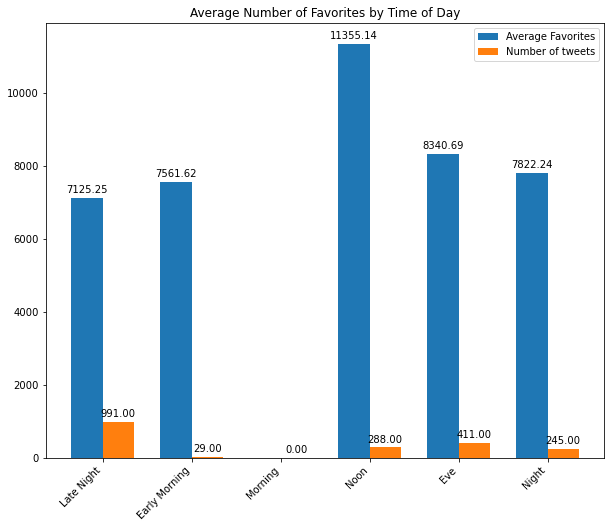

In [135]:
## used 
# https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
## as guidance in buildling the bar charts

fig, ax = plt.subplots()

x = np.arange(len(l))
width = .35

fav_avg = ax.bar(x=x - width/2, height=hourly_fav_count_stats['mean'].values, width=width, label='Average Favorites')
fav_ct = ax.bar(x=x + width/2, height=hourly_fav_count_stats['count'].values, width=width, label='Number of tweets')

ax.set_xticks(x)
ax.set_xticklabels(l, rotation=45, ha='right')
ax.set_title('Average Number of Favorites by Time of Day')
ax.legend()

def autolabel(axes):
    for y in axes:
        height = y.get_height()
        ax.annotate('{0:.{1}f}'.format(height, 2),
                    xy=(y.get_x() + y.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')



autolabel(fav_avg)
autolabel(fav_ct)

fig.set_size_inches(10,8)
    
plt.show();

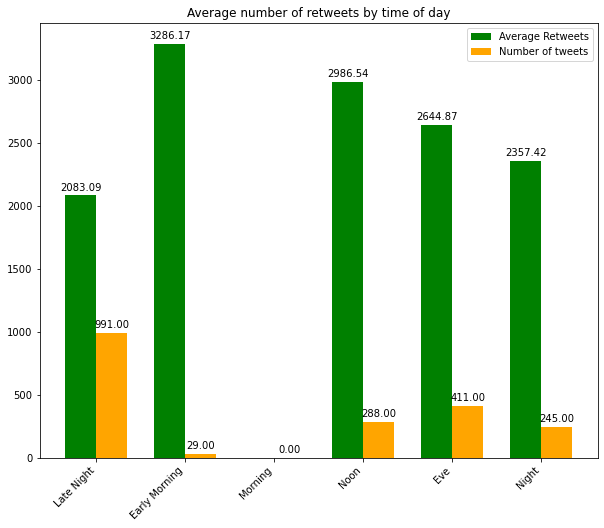

In [136]:
fig, ax = plt.subplots()

rt_avg = ax.bar(x=x - width/2, height=hourly_rt_count_stats['mean'].values, width=width, color='green', 
                label='Average Retweets')
rt_ct = ax.bar(x=x + width/2, height=hourly_rt_count_stats['count'].values, width=width, color='orange',
               label='Number of tweets')

ax.set_xticks(x)
ax.set_xticklabels(l, rotation=45, ha='right')
ax.set_title('Average number of retweets by time of day')
ax.legend()

autolabel(rt_avg)
autolabel(rt_ct)

fig.set_size_inches(10,8)

plt.show();

While we can see that the account mostly tweets late at night, it is the tweets in the early morning that get the highest average number of retweets, and posts at noon that get the highest average number of favorites. Naturally this does not tell us much about the behavior of those following the account as those retweets and favorites can take days to accumulate. What's just as fascinating however is there are no tweets in he morning period (from 8 am to 12 pm) at all!!